In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')

# dataset is too small for KNN (ony 300 instances). KNN learns bad and accuracy is low.
dataset_path = "/content/drive/MyDrive/animal_dataset"

image_size = (32, 32)
X = []
y = []

classes = os.listdir(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Here, we convert our pic to grayscale and append all informations into 1d vector

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        for file in os.listdir(cls_path):
            if file.endswith(".jpg") or file.endswith(".png"):
                img_path = os.path.join(cls_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, image_size)
                X.append(img.flatten())
                y.append(cls)

X = np.array(X)
y = np.array(y)

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Dataset shape:", X.shape, y_encoded.shape)
print("Classes:", le.classes_)

Dataset shape: (300, 1024) (300,)
Classes: ['cat' 'dog' 'panda']


In [37]:
# here we used 5 fold validetion with shuffle and port 42

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# for different k values we train our nural network for L1 and L2.

K_values = [1, 3, 5, 7, 9, 11]
accuracy_L1 = []
accuracy_L2 = []

for K in K_values:
    acc_folds_L1 = []
    acc_folds_L2 = []

    for train_index, val_index in kf.split(X, y_encoded):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]

        # Manhattan (L1)
        knn_L1 = KNeighborsClassifier(n_neighbors=K, metric='manhattan')
        knn_L1.fit(X_train, y_train)
        acc_L1 = knn_L1.score(X_val, y_val)
        acc_folds_L1.append(acc_L1)

        # Euclidean (L2)
        knn_L2 = KNeighborsClassifier(n_neighbors=K, metric='euclidean')
        knn_L2.fit(X_train, y_train)
        acc_L2 = knn_L2.score(X_val, y_val)
        acc_folds_L2.append(acc_L2)

    # Average accuracy across 5 folds
    accuracy_L1.append(np.mean(acc_folds_L1))
    accuracy_L2.append(np.mean(acc_folds_L2))

print(accuracy_L1)
print(accuracy_L2)

[np.float64(0.38666666666666666), np.float64(0.36666666666666664), np.float64(0.3933333333333333), np.float64(0.39666666666666667), np.float64(0.44666666666666666), np.float64(0.4133333333333334)]
[np.float64(0.3566666666666667), np.float64(0.3633333333333334), np.float64(0.36333333333333334), np.float64(0.39666666666666667), np.float64(0.40666666666666673), np.float64(0.39)]


0.44666666666666666
Best K: 9

Top 5 Predictions:


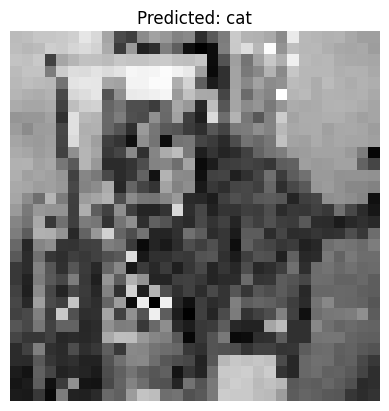

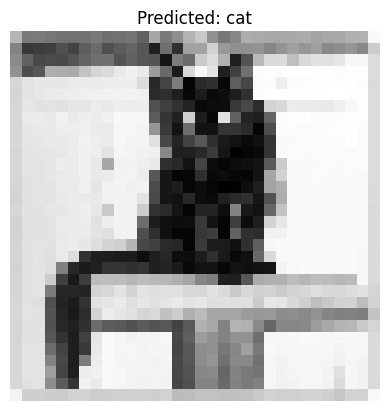

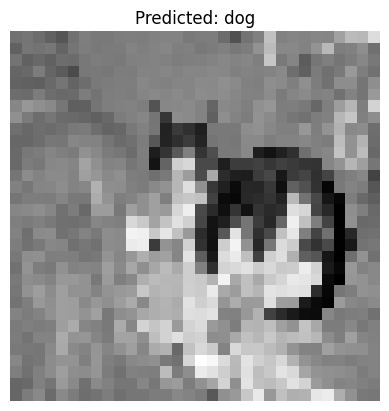

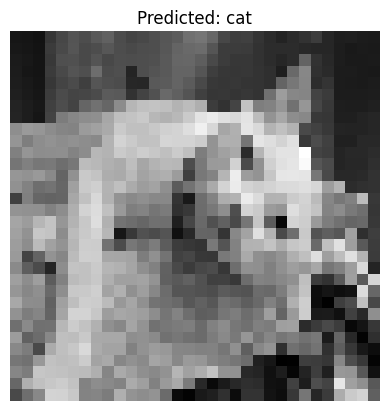

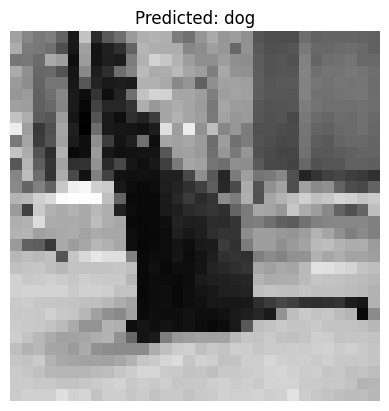

In [47]:
# we have selected last fold's validation set as sample test images
X_test = X_val
y_test = y_val

# Use the best K and metric (choose L1 or L2 based on results)
if np.max(accuracy_L1) > np.max(accuracy_L2):
    print(np.max(accuracy_L1))
    best_K_index = np.argmax(accuracy_L1)
    best_K = K_values[best_K_index]
    best_metric = 'manhattan'
else:
    print(np.max(accuracy_L2))
    best_K_index = np.argmax(accuracy_L2)
    best_K = K_values[best_K_index]
    best_metric = 'euclidean'

print(f"Best K: {best_K}")

best_knn = KNeighborsClassifier(n_neighbors=best_K, metric=best_metric)
best_knn.fit(X, y_encoded)

# Predict top 5
print("\nTop 5 Predictions:")
for i in range(5):
    img_vector = X_test[i].reshape(1, -1)
    pred = best_knn.predict(img_vector)
    plt.imshow(X_test[i].reshape(32,32), cmap='gray')
    plt.title(f"Predicted: {le.inverse_transform(pred)[0]}")
    plt.axis('off')
    plt.show()

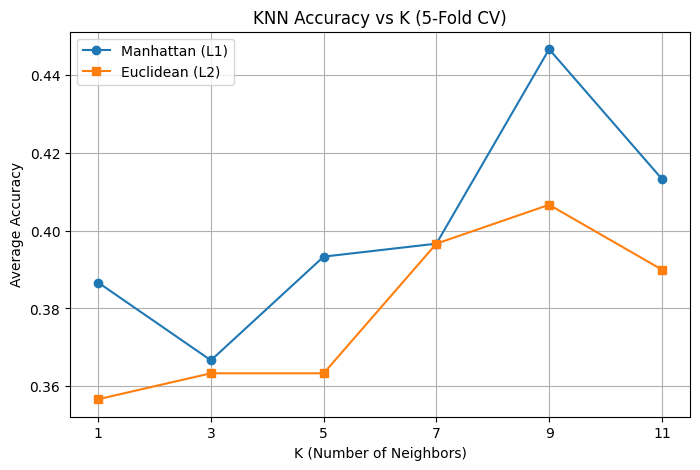

In [48]:
plt.figure(figsize=(8,5))
plt.plot(K_values, accuracy_L1, marker='o', label="Manhattan (L1)")
plt.plot(K_values, accuracy_L2, marker='s', label="Euclidean (L2)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.title("KNN Accuracy vs K (5-Fold CV)")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.show()

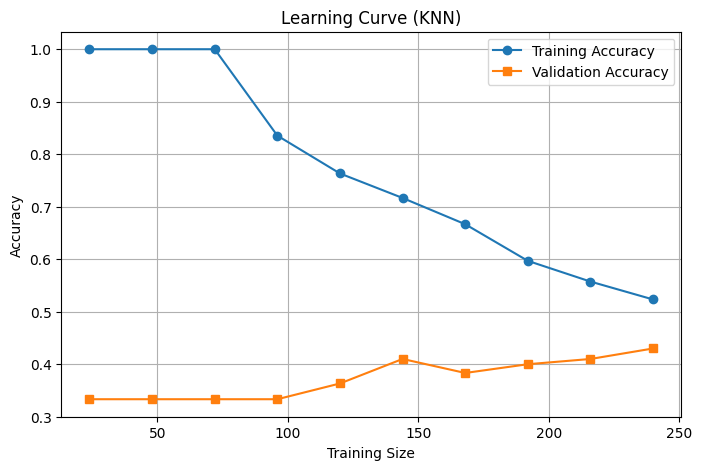

In [50]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=KNeighborsClassifier(n_neighbors=best_K, metric=best_metric),
    X=X,
    y=y_encoded,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, marker='o', label="Training Accuracy")
plt.plot(train_sizes, val_mean, marker='s', label="Validation Accuracy")
plt.title("Learning Curve (KNN)")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

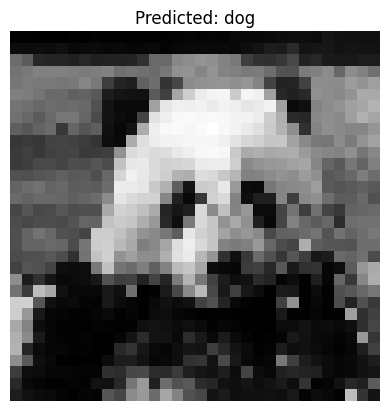

Actual: Panda


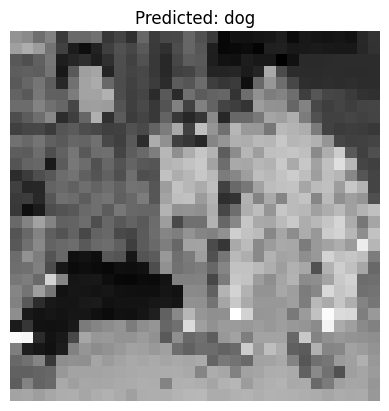

Actual: Dog


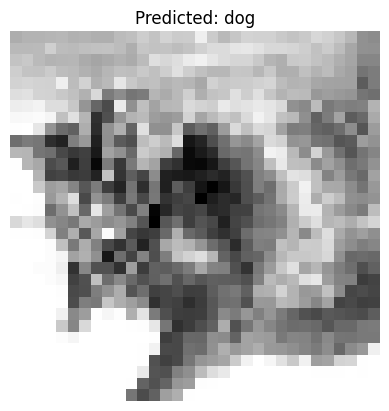

Actual: Cat


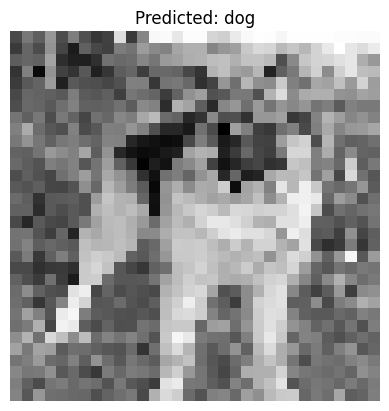

Actual: Dog


In [54]:
def predict_single_image(image_path, model, label_encoder, image_size=(32,32)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not found!")
        return

    img = cv2.resize(img, image_size)
    img_flat = img.flatten().astype("float32")

    img_flat = img_flat / 255.0

    img_flat = img_flat.reshape(1, -1)

    pred = model.predict(img_flat)
    pred_label = label_encoder.inverse_transform(pred)[0]

    plt.imshow(img, cmap="gray")
    plt.title(f"Predicted: {pred_label}")
    plt.axis("off")
    plt.show()

    return pred_label

image_path = "/content/drive/MyDrive/animal_dataset/panda/panda_00098.jpg"
predict_single_image(image_path, best_knn, le)
print("Actual: Panda")
image_path = "/content/drive/MyDrive/animal_dataset/dog/dogs_00040.jpg"
predict_single_image(image_path, best_knn, le)
print("Actual: Dog")
image_path = "/content/drive/MyDrive/animal_dataset/cat/cats_00040.jpg"
predict_single_image(image_path, best_knn, le)
print("Actual: Cat")
image_path = "/content/drive/MyDrive/animal_dataset/dog/dogs_00070.jpg"
predict_single_image(image_path, best_knn, le)
print("Actual: Dog")

# **Discussion and Analysis**

The KNN classifier was evaluated using Manhattan (L1) and Euclidean (L2) distances with 5-fold cross-validation. Results show that the Manhattan distance performs better, achieving the highest accuracy of 44.67% at K = 9, while the best Euclidean accuracy was 40.67%. This happens because L1 distance is more stable in high-dimensional data, whereas L2 is more sensitive to noise.

However, the overall accuracy is low for both metrics. This is mainly because the model uses raw pixel values, which do not capture important visual features such as edges, textures, or shapes. KNN also struggles in high-dimensional spaces (1024 features), leading to poor class separation.

# **How to Improve**

1. Use feature extraction (HOG, SIFT, PCA) instead of raw pixels.
2. Add more data to overcome overfitting and better taining.
3. Reduce dimensionality to avoid the “curse of dimensionality.”
4. Increase dataset size for better learning.
5. Replace KNN with a CNN model, which learns visual features automatically and performs much better on images.